### Import Libraries

In [2]:
!pip install -q ultralytics opencv-python-headless numpy scipy matplotlib tqdm ffmpeg-python

In [3]:
import cv2
import numpy as np
from ultralytics import YOLO
from scipy.stats import entropy
from scipy.spatial import distance_matrix
from tqdm import tqdm
import ffmpeg
import matplotlib.pyplot as plt
from IPython.display import HTML
from base64 import b64encode
import os

### Constants

In [12]:
VIDEO_IN = "/content/2431853-hd_1920_1080_25fps.mp4"
TEMP_OUT = "/content/temp_output.mp4"
FINAL_OUT = "/content/eco_entropy_output.mp4"
YOLO_WEIGHTS = "yolov8l.pt"
RESIZE_FACTOR = 2
BINS = 12           # velocity -> entropy
USE_GPU = True

### Load Model with Weights

In [13]:
print("Loading model:", YOLO_WEIGHTS)
model = YOLO(YOLO_WEIGHTS)

Loading model: yolov8l.pt


### Video I/O

In [14]:
cap = cv2.VideoCapture(VIDEO_IN)
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
fps = cap.get(cv2.CAP_PROP_FPS) or 25.0
orig_w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
orig_h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
w = orig_w // RESIZE_FACTOR
h = orig_h // RESIZE_FACTOR

fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(TEMP_OUT, fourcc, fps, (w, h))

### Centroid matching (greedy nearest neighbor)

In [15]:
def match_centroids(prev_c, cur_c, max_distance=1000):
    """
    prev_c, cur_c: lists of (x,y)
    returns list of (cur_idx, prev_idx) matches
    greedy match by nearest neighbor, prevents reuse
    """
    if len(prev_c) == 0 or len(cur_c) == 0:
        return []

    prev_arr = np.array(prev_c)
    cur_arr = np.array(cur_c)
    D = distance_matrix(cur_arr, prev_arr)  # shape (len(cur), len(prev))
    matches = []
    used_prev = set()
    used_cur = set()
    # greedy: find global min repeatedly
    while True:
        idx = np.unravel_index(np.argmin(D, axis=None), D.shape)
        cur_i, prev_i = idx
        min_val = D[cur_i, prev_i]
        if min_val > max_distance:
            break
        if cur_i in used_cur or prev_i in used_prev:
            D[cur_i, prev_i] = np.inf
            if np.isinf(D).all():
                break
            continue
        matches.append((cur_i, prev_i, min_val))
        used_cur.add(cur_i)
        used_prev.add(prev_i)
        # block out those rows/cols
        D[cur_i, :] = np.inf
        D[:, prev_i] = np.inf
        if np.isinf(D).all():
            break
    return matches

### **Processing loop**

In [16]:
prev_centroids = []
frame_id = 0
entropy_values = []
frame_entropy_list = []  # store per-frame value even if zero

print(f"Processing {total_frames} frames (resized {w}x{h}) ...")
for _ in tqdm(range(total_frames), desc="Frames"):
    ret, frame = cap.read()
    if not ret:
        break

    frame = cv2.resize(frame, (w, h))
    # run detection - returns results object
    results = model(frame, verbose=False)
    boxes = results[0].boxes.xyxy.cpu().numpy() if len(results) > 0 else np.array([])

    # filter boxes by confidence if desired (ultralytics provides conf)
    centroids = []
    for det in boxes:
        x1, y1, x2, y2 = det[:4]
        cx, cy = (x1 + x2) / 2.0, (y1 + y2) / 2.0
        centroids.append((float(cx), float(cy)))
        # draw bbox
        cv2.rectangle(frame, (int(x1), int(y1)), (int(x2), int(y2)), (16, 200, 16), 2)

    # match to prev and compute speeds (pixel displacement per frame)
    speeds = []
    if len(prev_centroids) > 0 and len(centroids) > 0:
        matches = match_centroids(prev_centroids, centroids, max_distance=200)  # tune
        for cur_i, prev_i, dist in matches:
            (cx, cy) = centroids[cur_i]
            (px, py) = prev_centroids[prev_i]
            dx = cx - px
            dy = cy - py
            # pixel displacement magnitude
            disp = np.sqrt(dx * dx + dy * dy)
            speeds.append(disp)

    # compute histogram-based entropy from speeds
    if len(speeds) > 0:
        hist, _ = np.histogram(speeds, bins=BINS, density=True)
        # avoid zeros in entropy input
        S = entropy(hist + 1e-12)
    else:
        S = 0.0

    entropy_values.append(S)
    frame_entropy_list.append(S)

    # draw entropy text
    cv2.putText(frame, f"Entropy: {S:.4f}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX,
                1.0, (0, 165, 255), 2, cv2.LINE_AA)

    # draw a small rolling sparkline
    pad = 5
    spark_h = 60
    spark_w = 200
    spark_x = w - spark_w - pad
    spark_y = pad
    # background box
    cv2.rectangle(frame, (spark_x-1, spark_y-1), (spark_x+spark_w+1, spark_y+spark_h+1), (20,20,20), -1)
    # compute sparkline points from last N entropy values
    Nspark = min(100, len(entropy_values))
    if Nspark > 1:
        vals = np.array(entropy_values[-Nspark:])
        # normalize to [0, spark_h]
        vmin, vmax = vals.min(), vals.max() if vals.max()!=vals.min() else vals.min()+1e-6
        ys = spark_y + spark_h - ((vals - vmin) / (vmax - vmin + 1e-12) * (spark_h - 10)) - 5
        xs = np.linspace(spark_x+5, spark_x+spark_w-5, Nspark).astype(int)
        pts = np.vstack([xs, ys]).T.astype(int)
        for i in range(len(pts)-1):
            cv2.line(frame, tuple(pts[i]), tuple(pts[i+1]), (255,255,255), 1)

    # write frame
    out.write(frame)
    prev_centroids = centroids
    frame_id += 1

cap.release()
out.release()

Processing 1513 frames (resized 960x540) ...


Frames: 100%|██████████| 1513/1513 [01:02<00:00, 24.20it/s]


### Re-encode to H.264 and Play the Output

In [ ]:
print("Re-encoding to H.264 (final output)...")
(
    ffmpeg
    .input(TEMP_OUT)
    .output(FINAL_OUT, vcodec='libx264', pix_fmt='yuv420p', crf=23, loglevel="error")
    .run(overwrite_output=True)
)

print("Processing complete. Final output:", FINAL_OUT)


mp4 = open(FINAL_OUT,'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
display(HTML(f"""<video width=900 controls autoplay loop muted>
                <source src="{data_url}" type="video/mp4"></video>"""))

### Plot Entropy

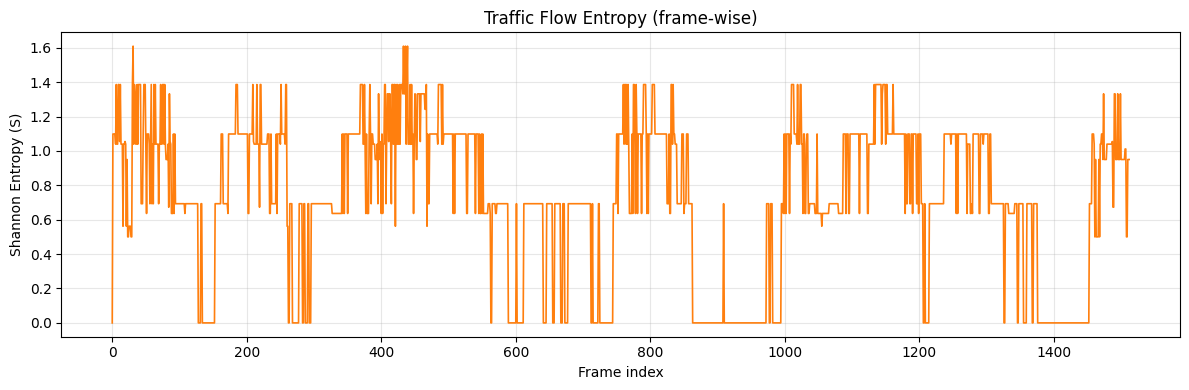

In [18]:
plt.figure(figsize=(12,4))
plt.plot(entropy_values, color='tab:orange', linewidth=1.2)
plt.title("Traffic Flow Entropy (frame-wise)")
plt.xlabel("Frame index")
plt.ylabel("Shannon Entropy (S)")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

### Final Stats

Mean S: 0.7231
Max S: 1.6094
Min S: 0.0000


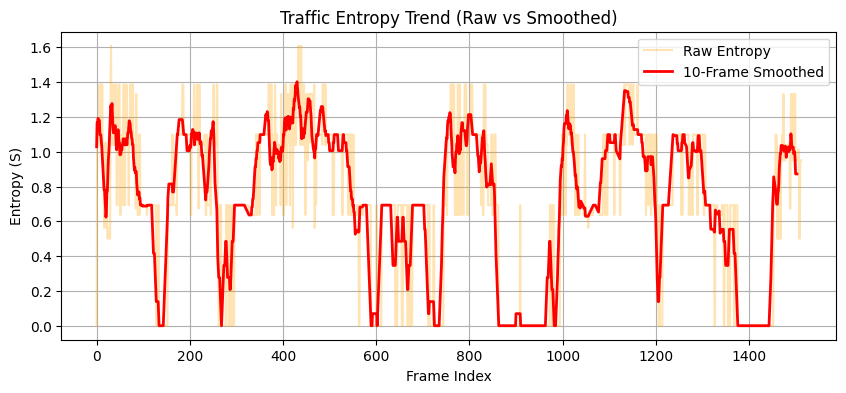

In [22]:
entropy_data = np.array(entropy_values)

# Summary Stats
mean_S = np.mean(entropy_data)
max_S = np.max(entropy_data)
min_S = np.min(entropy_data)
var_S = np.var(entropy_data)
print(f"Mean S: {mean_S:.4f}")
print(f"Max S: {max_S:.4f}")
print(f"Min S: {min_S:.4f}")

# Entropy Trend Refinement
window = 10
smooth_entropy = np.convolve(entropy_data, np.ones(window)/window, mode='valid')

plt.figure(figsize=(10,4))
plt.plot(entropy_data, color='orange', alpha=0.3, label='Raw Entropy')
plt.plot(smooth_entropy, color='red', linewidth=2, label=f'{window}-Frame Smoothed')
plt.title("Traffic Entropy Trend (Raw vs Smoothed)")
plt.xlabel("Frame Index")
plt.ylabel("Entropy (S)")
plt.legend()
plt.grid(True)
plt.show()